In [1]:
%matplotlib notebook
import pandas as pd
import numpy
import pprint
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests as gctest
from sklearn.linear_model import LinearRegression

In [2]:
pp = pprint.PrettyPrinter(indent=4)

In [3]:
# read in the dataset
under5 = pd.read_csv("data/under5.csv")
vaccine = pd.read_csv("data/vaccine.csv")

In [4]:
under5 = under5.set_index("ISO Code")
vaccine = vaccine.set_index(["ISO_code", "Vaccine"]).sort_index(level="ISO_code")

In [5]:
# select only data from 1980 to 2015
under5 = under5.iloc[:, list(range(30,66))]
vaccine = vaccine.iloc[:, list(range(35, -1, -1))]
vaccine = vaccine[vaccine.columns[::-1]]

<IPython.core.display.Javascript object>


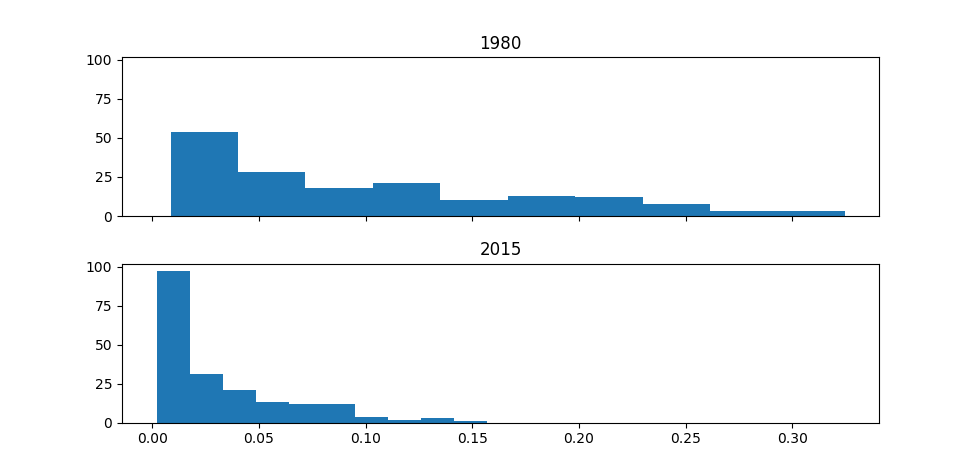

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x110371208>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x1106a7518>]], dtype=object)

In [6]:
under5.iloc[:, [0, 35]].hist(grid=False, sharex=True, sharey=True, layout=(2,1))

In [7]:
# function for testing time series stationarity using Augmented Dickey-Fuller Test
# it takes in a time series and significant level as parameters
# it returns boolean value indicating there are trend in the time series or not
# 
# adfuller takes a time series data and test if it is stationary or not
def test_stationarity(timeseries, sig=0.05):
    dftest = adfuller(timeseries, autolag="AIC")
    if dftest[0] < dftest[4]["1%"]:
        return 0.01 <= sig
    elif dftest[0] < dftest[4]["5%"]:
        return 0.05 <= sig
    elif dftest[0] < dftest[4]["10%"]:
        return 0.10 <= sig
    else:
        return False

In [8]:
###############################
# test for individual dataset #
###############################

In [9]:
# test for stationary of under5 for each country
under5_sig = []
for c in under5.index:
    # extract one record from under5 and convert the data to numeric 
    # and then interpolate the missing values in between the data
    # and then remove nan data at the beginning of the time series
    # this is to prepare the data for the Augmented Dickey-Fuller Test
    data = under5.ix[c].to_frame().apply(pd.to_numeric, errors="coerce").interpolate().dropna()
    have_trend = False
    # only country with enough record are tested, others are assumed stationary
    if len(data) > 9:
        # a list is needed to pass to adfuller but data.values.tolist() gives 
        # a column instead of a row so use sum(x, []) to convert it to a single list
        have_trend = test_stationarity(sum(data.values.tolist(), []), 0.05)
    if have_trend:
        under5_sig.append(c)
print("Country with trend in under 5 mortarity rates")
pp.pprint(under5_sig)

Country with trend in under 5 mortarity rates
[   'ALB',
    'DZA',
    'AND',
    'ATG',
    'ARG',
    'BHS',
    'BGD',
    'BRB',
    'BLZ',
    'BEN',
    'BOL',
    'BWA',
    'CHL',
    'CHN',
    'COL',
    'CRI',
    'HRV',
    'CUB',
    'CYP',
    'CZE',
    'DNK',
    'DMA',
    'DOM',
    'ERI',
    'EST',
    'ETH',
    'FIN',
    'GAB',
    'DEU',
    'GRC',
    'GTM',
    'GNB',
    'IDN',
    'IRN',
    'JAM',
    'JOR',
    'KWT',
    'LAO',
    'LSO',
    'LBY',
    'MWI',
    'MYS',
    'MUS',
    'MEX',
    'MAR',
    'NPL',
    'NZL',
    'NIC',
    'NIU',
    'NOR',
    'PRY',
    'PHL',
    'PRT',
    'KNA',
    'LCA',
    'SMR',
    'SAU',
    'SRB',
    'SGP',
    'SVK',
    'SVN',
    'ZAF',
    'ESP',
    'LKA',
    'SUR',
    'SWZ',
    'SWE',
    'SYR',
    'THA',
    'MKD',
    'TON',
    'UGA',
    'VUT',
    'VEN',
    'VNM',
    'YEM',
    'ZMB',
    'ZWE']


In [10]:
# test for stationary of each vaccine in each country
vaccine_sig = {}
for c, v in vaccine.index:
    # the structure for vaccine is different as it has 2 indice so the 
    # syntax here is a little bit different
    data = vaccine.ix[c].ix[v].to_frame().apply(pd.to_numeric, errors="coerce")[v].interpolate().dropna().to_frame()
    have_trend = False
    if len(data) > 9:
        have_trend = test_stationarity(sum(data.values.tolist(), []), 0.05)
    if have_trend:
        vaccine_sig.setdefault(c, []).append(v)
print("Vaccine introduced in each country")
pp.pprint(vaccine_sig)

/Users/ddyjis/anaconda/lib/python3.5/site-packages/statsmodels/regression/linear_model.py:1353: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/Users/ddyjis/anaconda/lib/python3.5/site-packages/statsmodels/regression/linear_model.py:660: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/ddyjis/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/ddyjis/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:1118: RuntimeWarning: invalid value encountered in multiply
  cov_p = self.normalized_cov_params * scale


Vaccine introduced in each country
{   'AFG': ['VAD1'],
    'AGO': ['MCV1'],
    'ALB': ['Pol3'],
    'AND': ['TT2plus'],
    'ARE': ['HepB_BD', 'Pol3'],
    'ARG': ['BCG', 'DTP3', 'MCV1', 'Pol3'],
    'ARM': ['MCV1', 'Pol3', 'TT2plus'],
    'ATG': ['Pol3'],
    'AUS': ['DTP3', 'HepB3', 'Pol3'],
    'AUT': ['HepB3', 'HepB_BD'],
    'AZE': ['BCG', 'DTP3', 'MCV1', 'TT2plus'],
    'BEL': ['DTP3', 'RCV1', 'TT2plus'],
    'BEN': ['BCG', 'MCV1', 'Pol3'],
    'BFA': ['DTP1', 'PAB'],
    'BGR': ['Pol3', 'TT2plus'],
    'BHR': ['DTP3', 'MCV1', 'Pol3', 'TT2plus'],
    'BHS': ['DTP3', 'HepB_BD', 'MCV1', 'Pol3'],
    'BIH': ['DTP3'],
    'BLR': ['MCV1', 'TT2plus'],
    'BLZ': ['DTP3', 'MCV1', 'TT2plus'],
    'BOL': ['DTP3', 'Pol3'],
    'BRA': ['BCG', 'TT2plus', 'YFV'],
    'BRB': ['DTP3', 'MCV1', 'Pol3', 'TT2plus'],
    'BRN': ['DTP3', 'HepB3', 'MCV1', 'Pol3'],
    'CAF': ['BCG'],
    'CAN': ['DTP3', 'Pol3'],
    'CHE': ['Pol3'],
    'CHL': ['BCG', 'DTP3', 'MCV1', 'Pol3'],
    'CHN': ['BCG', 'DTP

In [11]:
##########################################
# test for relationship between datasets #
##########################################

In [12]:
# function for removing trend pattern if the time series is not stationary
def detrend(x, y):
    model = LinearRegression()
    model.fit(x, y)
    trend = model.predict(x)
    return [y[i] - trend[i] for i in range(len(y))]

In [13]:
# check if the two data ISO code are inconsistent
for c, v in vaccine.index:
    if c not in under5.index:
        print(c)

In [14]:
# check granger causality
vaccine_granger_cause = []

for c, v in vaccine.index:
    # get data the way same as above, u for under5 and v for vaccine
    v_data = vaccine.ix[c].ix[v].to_frame().apply(pd.to_numeric, errors="coerce")[v].interpolate().dropna().to_frame()
    u_data = under5.ix[c].to_frame().apply(pd.to_numeric, errors="coerce").interpolate().dropna()

    # get only the common years of results
    length = min(len(u_data), len(v_data))
    u_data = u_data[-length:]
    v_data = v_data[-length:]

    # test if the time series have trend in them
    v_has_trend = False
    if len(v_data) > 9:
        v_has_trend = test_stationarity(sum(v_data.values.tolist(), []), 0.05)
    u_has_trend = False
    if len(u_data) > 9:
        u_has_trend = test_stationarity(sum(u_data.values.tolist(), []), 0.05)
    
    # remove trend and make stationary time series for granger causality test
    if v_has_trend:
        x = [int(i) for i in v_data.index]
        x = numpy.reshape(x, (len(x), 1))
        y = v_data.values
        y = numpy.reshape(y, (len(y), 1))
        v_detrend = detrend(x, y)
        v_detrend = [float(i) for i in v_detrend]
    else:
        v_detrend = [float(i) for i in v_data.values]
    if u_has_trend:
        x = [int(i) for i in u_data.index]
        x = numpy.reshape(x, (len(x), 1))
        y = u_data.values
        y = numpy.reshape(y, (len(y), 1))
        u_detrend = detrend(x, y)
        u_detrend = [float(i) for i in u_detrend]
    else:
        u_detrend = [float(i) for i in u_data.values]

    d = {"Under5": u_detrend, "Vaccine": v_detrend}
    try:
        # grangercausalitytests test if the second time series "granger-cause" the first one
        # it takes at least 2 parameters: data and maxlag
        # data should contain exactly two time series of the same length
        # maxlag states the maximum lag between the two time series
        # 
        # grangercausalitytests contains 4 statistical tests to test if past values of the
        # second series has statistically significant effect on current value of the first series
        max_lag = 6
        test = gctest(pd.DataFrame(data=d), max_lag, verbose=False)
        # lags stores the possible number of lags with average p-value less than 0.05
        lags = []
        for lag in test:
            average_p = 0
            for k in test[lag][0]:
                average_p += test[lag][0][k][1]/4
            if average_p < 0.05:
                lags.append(lag)
        if max(lags) < max_lag:
            vaccine_granger_cause.append(tuple([c, v, max(lags)]))
    except ValueError:
        pass

/Users/ddyjis/anaconda/lib/python3.5/site-packages/statsmodels/regression/linear_model.py:1353: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/Users/ddyjis/anaconda/lib/python3.5/site-packages/statsmodels/regression/linear_model.py:660: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/ddyjis/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/ddyjis/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:1118: RuntimeWarning: invalid value encountered in multiply
  cov_p = self.normalized_cov_params * scale
/Users/ddyjis/anaconda/lib/python3.5/site-packages/statsmodels/regression/linear_model.py:1353: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


In [15]:
# show the results
country_improved = {}
vaccine_count = {k: 0 for k in list(vaccine.index.levels[1])}
for c, v, l in vaccine_granger_cause:
    country_improved.setdefault(c, []).append(v)
    vaccine_count[v] += 1
print("Country with mortarity rate 'Granger caused'")
pp.pprint(country_improved)
print("Counts of vaccine that 'Granger caused' change in mortarity")
pp.pprint(vaccine_count)

Country with mortarity rate 'Granger caused'
{   'AFG': ['DTP3', 'Pol3', 'TT2plus'],
    'AGO': ['BCG', 'Pol3', 'TT2plus'],
    'ALB': ['DTP3', 'HepB3', 'TT2plus'],
    'ARE': ['BCG', 'DTP3', 'HepB3', 'Pol3'],
    'ARG': ['BCG', 'Pol3'],
    'ATG': ['DTP3', 'MCV1'],
    'AUS': ['DTP3', 'MCV1'],
    'AUT': ['DTP3', 'Pol3'],
    'AZE': ['DTP3', 'MCV1', 'Pol3'],
    'BDI': ['BCG', 'DTP3', 'MCV1', 'Pol3'],
    'BEL': ['Hib3', 'MCV1', 'Pol3'],
    'BEN': ['TT2plus'],
    'BFA': ['DTP3', 'Pol3'],
    'BGD': ['BCG', 'DTP3', 'MCV1', 'TT2plus'],
    'BGR': ['HepB3', 'MCV1'],
    'BHR': ['HepB3'],
    'BHS': ['MCV1', 'TT2plus'],
    'BIH': ['Pol3'],
    'BLR': ['DTP3', 'Pol3'],
    'BRA': ['DTP3', 'HepB3', 'MCV1', 'Pol3', 'TT2plus'],
    'BRB': ['MCV1'],
    'BRN': ['MCV1'],
    'BTN': ['BCG', 'HepB3', 'MCV1', 'Pol3'],
    'BWA': ['BCG', 'HepB3', 'MCV1', 'Pol3'],
    'CAF': ['DTP3', 'MCV1', 'Pol3'],
    'CHE': ['MCV1'],
    'CHN': ['BCG', 'DTP3', 'MCV1', 'Pol3'],
    'COD': ['BCG', 'DTP3', 'MCV1